# 株式市場のデータ解析

株のデータを解析して、未来の株価が分かったら大金持ちになれるかも知れません。
それはさておき、Pythonと周辺ライブラリを使うと、株価データのような、時系列データの解析も比較的簡単に行う事ができます。

次のような課題について考えて行くことにしましょう。

    1.) 株価の時間による変化を見てみる。
    2.) 日ごとの変動を可視化する。
    3.) 移動平均を計算する
    4.) 複数の株価の終値の相関を計算する
    4.) 複数の株価の変動の関係を見る
    5.) 特定の株のリスクを計算する
    6.) シミュレーションを使った未来の予測

#### 株価データの基本

pandasを使って株価のデータを扱う基本を学んで行きましょう。

In [2]:
# 必要なライブラリをimportします
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# 可視化のためのセットです。
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Yahooからデータを読み込めるようにします
#from pandas.io.data import DataReader
#@ pandas.io.dataはなくなったので、pandas_datareaderを使います。
import pandas_datareader as pdr

# Pythonで日付と時刻を扱うためのモジュールです
from datetime import datetime

# Python2を使っている場合は必要です
# from __future__ import division

Let's use Yahoo and pandas to grab some data for some tech stocks.

In [4]:
# 所謂ハイテク企業の株価を扱ってみます。
tech_list = ['AAPL','GOOG','MSFT','AMZN']

# 直近1年間のデータを使ってみましょう。
end = datetime.now()
start = datetime(end.year - 1,end.month,end.day)

# それぞれの企業ごとに、Yahooのサイトからデータを取得します
for stock in tech_list:   
    # それぞれの名前でDataFrameを作ります。
    # globals()[stock] = DataReader(stock, 'yahoo', start, end)
    #@ pandas_datareaderを使います。　もし動かなかったら、Q&Aへお問い合わせください。
    globals()[stock] = pdr.DataReader(stock, 'yahoo', start, end)    

globals()は文字列をそのままPythonのコードにするためで、tech_listに並んでいる文字列がそのままDataFrameになります。

まずは、感覚を掴むために、Appleの株価をみていきましょう。

In [5]:
# データの概観を掴むことができます。
AAPL.describe()

,High,Low,Open,Close,Volume,Adj Close
count,254.000000,254.000000,254.000000,254.000000,2.540000e+02,254.000000
mean,280.528031,274.001260,276.888268,277.560983,3.513292e+07,276.438074
std,50.864609,49.795588,50.263819,50.426845,1.688769e+07,50.984913
min,198.070007,192.580002,195.410004,193.339996,1.165440e+07,191.059784
25%,237.769997,234.292496,235.407497,235.954998,2.396200e+07,234.058132
50%,278.250000,268.934998,272.534988,274.274994,3.052870e+07,273.269531
75%,318.949989,312.805008,315.667488,316.690010,4.057110e+07,315.269402
max,399.820007,386.970001,396.690002,393.429993,1.067212e+08,393.429993


In [6]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2019-07-22 to 2020-07-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       254 non-null    float64
 1   Low        254 non-null    float64
 2   Open       254 non-null    float64
 3   Close      254 non-null    float64
 4   Volume     254 non-null    float64
 5   Adj Close  254 non-null    float64
dtypes: float64(6)
memory usage: 13.9 KB


出来高と終値をプロットしてみましょう。

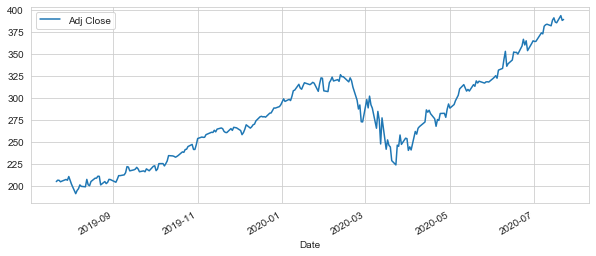

In [7]:
# 終値の時系列をプロットしてみます。
AAPL['Adj Close'].plot(legend=True,figsize=(10,4))

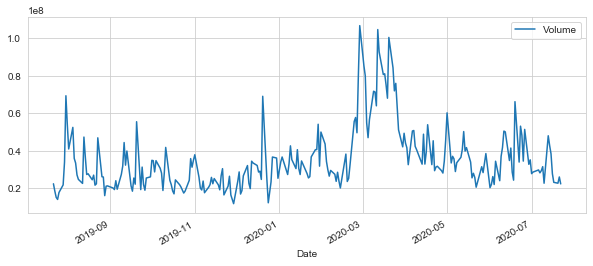

In [8]:
# 今度は出来高（1日に取引が成立した株の数）をプロットします。
AAPL['Volume'].plot(legend=True,figsize=(10,4))

単純な折れ線グラフではなく、移動平均線（moving average）と呼ばれるグラフを描いてみましょう。

参考資料

1.) https://ja.wikipedia.org/wiki/%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87

2.) http://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp

<hr>

In [11]:
# pandasはもともと金融情報を扱うために作られていたので、色々な機能があります。

# 間隔ごとに移動平均を描いてみます。
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA {}".format(str(ma))
    # AAPL[column_name]=pd.rolling_mean(AAPL['Adj Close'],ma)
    #@ 移動平均を求めるやり方がわかりました。以下のように書きます。
    AAPL[column_name] = AAPL['Adj Close'].rolling(ma).mean()

描画してみます。

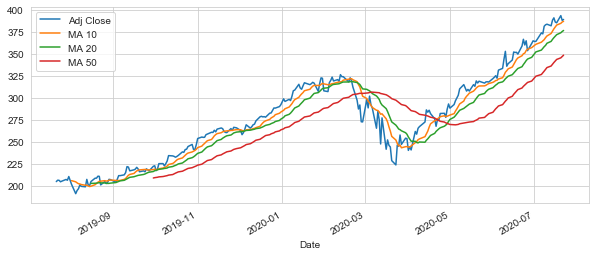

In [12]:
AAPL[['Adj Close','MA 10','MA 20','MA 50']].plot(subplots=False,figsize=(10,4))

#### Section 2 - 株価と日ごとの変動

株式投資のリスクを管理するために、日ごとの変動について計算してみます。

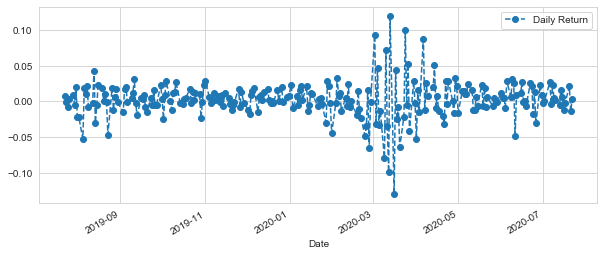

In [13]:
# pct_changeを使うと、変化の割合を計算できます。
AAPL['Daily Return'] = AAPL['Adj Close'].pct_change()
# 変化率をプロットしてみましょう。
AAPL['Daily Return'].plot(figsize=(10,4),legend=True,linestyle='--',marker='o')

前日比（％）のヒストグラムを描いてみましょう。Seabornを使えば、KDEプロットも一緒に描けます。

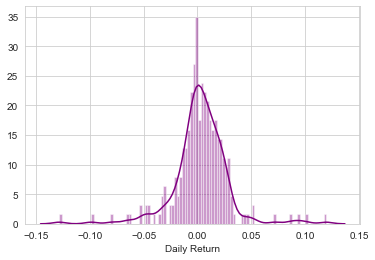

In [14]:
# NaNを取り除くコードを書いておく必要があります。
sns.distplot(AAPL['Daily Return'].dropna(),bins=100,color='purple')

# こんなコードでもOK
# AAPL['Daily Return'].hist(bins=100)

ハイテク4社の株価を1つのDataFrameにまとめてみましょう。

In [16]:
# 簡単なコードで実現出来ます。
#closing_df = DataReader(['AAPL','GOOG','MSFT','AMZN'],'yahoo',start,end)['Adj Close']
#@ pandas_datareaderを使います。
closing_df = pdr.DataReader(['AAPL','GOOG','MSFT','AMZN'],'yahoo',start,end)['Adj Close']

In [17]:
# 確認しておきましょう。
closing_df.head()

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2019-07-22,204.776108,1138.069946,136.747269,1985.630005
2019-07-23,206.376984,1146.209961,137.596817,1994.489990
2019-07-24,206.209015,1137.810059,139.009445,2000.810059
2019-07-25,204.578476,1132.119995,138.485886,1973.819946
2019-07-26,205.289978,1250.410034,139.621902,1943.050049


アップル社でやったように、終値の日ごとの変化を計算します。

In [18]:
# 別のDataFrameにしておきます。
tech_rets = closing_df.pct_change()

終値の変化を会社ごとに比較できるようになりました。

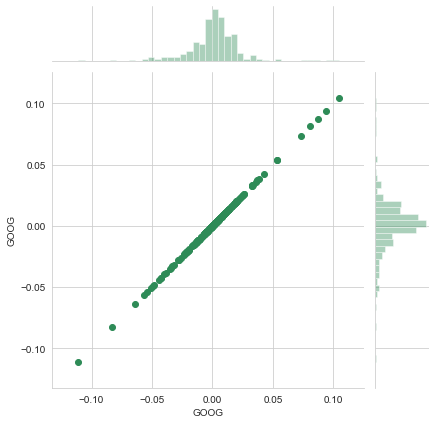

In [19]:
# Google同士なら、完全に相関します。
sns.jointplot('GOOG','GOOG',tech_rets,kind='scatter',color='seagreen')

相関があるかどうか、別の会社同士を比べてみましょう。

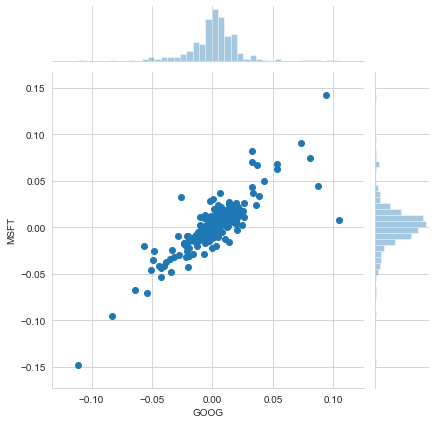

In [20]:
# GoogleとMicrosoftを比べてみます。
sns.jointplot('GOOG','MSFT',tech_rets,kind='scatter')

2つの会社の株価の変化率は相当関係があることがわかります。pearsonrは相関係数(正確には、ピアソン積率相関係数）ですが、0.52と正に相関していることを示しています。

url - https://ja.wikipedia.org/wiki/%E7%9B%B8%E9%96%A2%E4%BF%82%E6%95%B0

相関係数について、感覚的な理解を助けてくれる図を紹介しておきます。

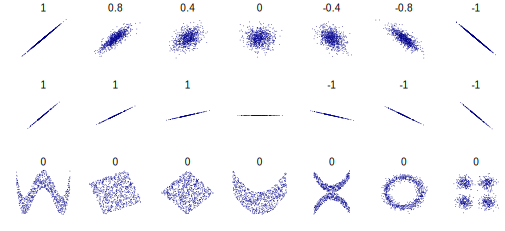

In [21]:
from IPython.display import SVG
SVG(url='http://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg')

2社の間の比較は、色々な組み合わせを考える事が出来ますが、Seabornを使うと、このような比較をすべてのパターンについて、簡単にやってくれます。
それが、sns.pairplot() です。

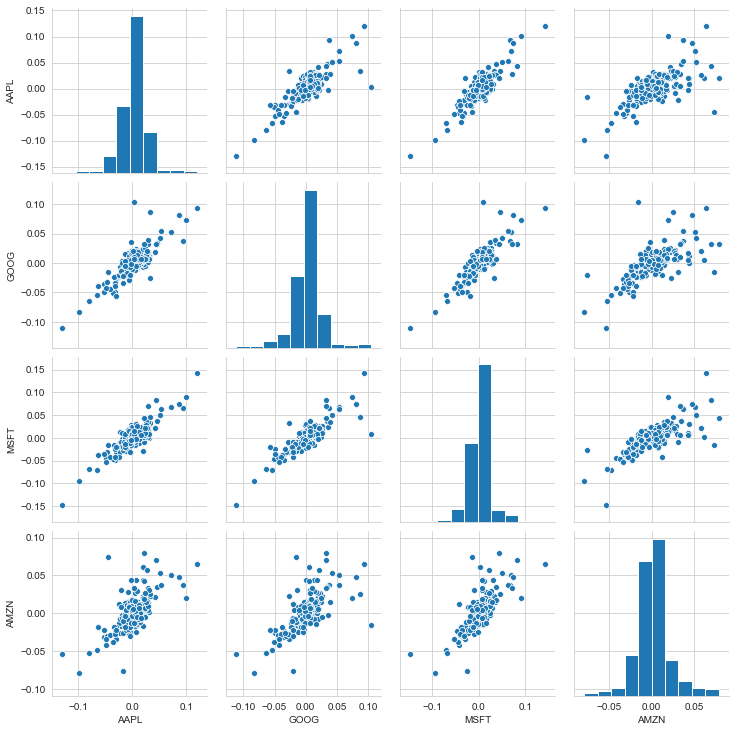

In [22]:
# こんな簡単なコードで、描けます。
sns.pairplot(tech_rets.dropna())

すべてのパターンが一目でわかります。全体を見渡すと、GoogleとAmazonの関係が少し興味深いように見えます。
このようなプロットを簡単に作れるseabornですが、さらにすごい機能があります。PairGrid()を使うと、上側と下側で別の種類のグラフを描くことができます。実際にやってみましょう。

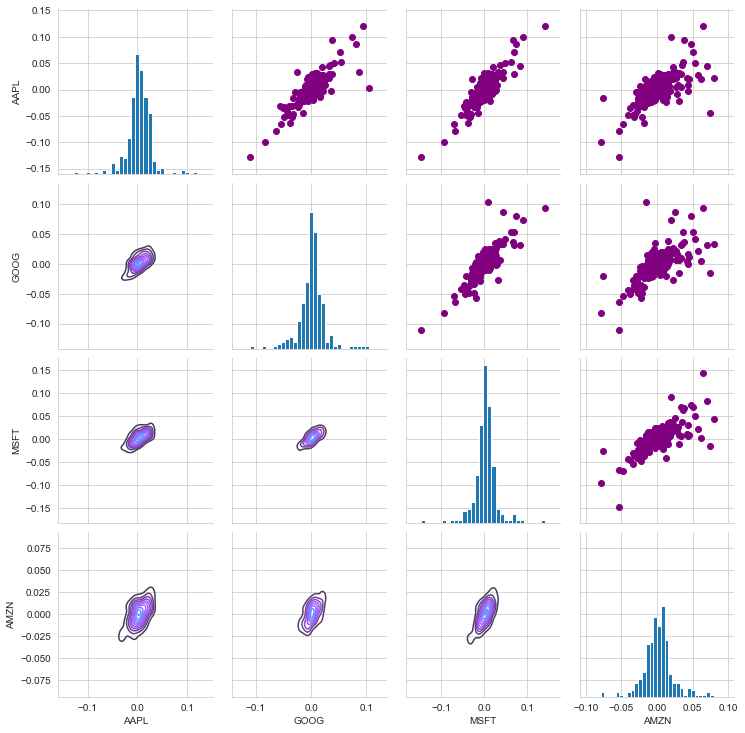

In [23]:
# データを格納しているDataFrameを引数にして、PairGridを作ります。
returns_fig = sns.PairGrid(tech_rets.dropna())

# 右上側に描くグラフの種類を指定します。
returns_fig.map_upper(plt.scatter,color='purple')

# 同じように、左下側には、KDEプロットを描くことにしましょう。
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# 対角線上には、ヒストグラムを描くことにします。
returns_fig.map_diag(plt.hist,bins=30)

終値についても同じ事ができます。

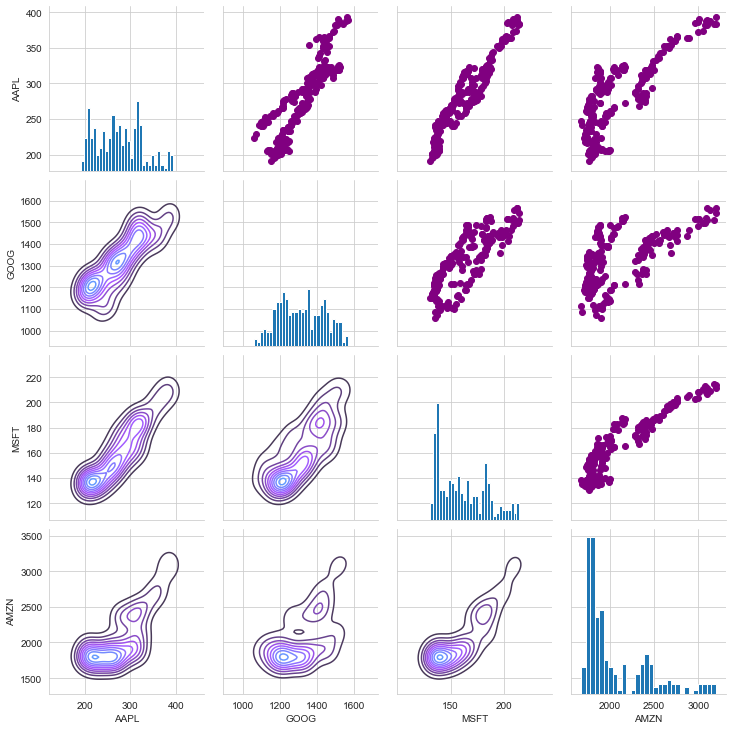

In [24]:
# この部分以外は同じコードです。
returns_fig = sns.PairGrid(closing_df)

returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(plt.hist,bins=30)

相関係数を表示したヒートマップを描くこともできます。

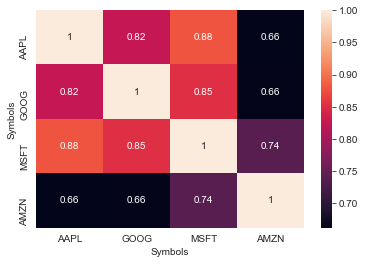

In [25]:
# 相関係数の数値が欲しい場合には、heatmapが使えます。
sns.heatmap(tech_rets.corr(), annot=True)

すべてのハイテク企業の株価の変動は、正の相関を示していることは驚きです。

次は、リスクを管理するためのデータ解析について学んでいきましょう。

#### リスク解析

株式投資のリスクを測る方法にはいろいろありますが、折角日々の変化率が分かっているので、この変化率の変動を計算して、リスクを見積もってみることにします。

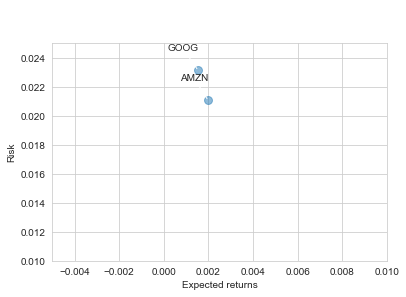

In [26]:
# リスクの基本はその株価の変動幅です。
rets = tech_rets.dropna()

area = np.pi*20

plt.scatter(rets.mean(), rets.std(),alpha = 0.5,s =area)

# Set the x and y limits of the plot (optional, remove this if you don't see anything in your plot)
plt.ylim([0.01,0.025])
plt.xlim([-0.005,0.01])

#Set the plot axis titles
plt.xlabel('Expected returns')
plt.ylabel('Risk')

# グラフにアノテーションを付けます。詳しくは、以下を参照してみてください。
# http://matplotlib.org/users/annotations_guide.html
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 20),
        textcoords = 'offset points', ha = 'right',
        arrowprops = dict(arrowstyle='-', connectionstyle= 'arc3'))


#### Value at Risk

ある一定の確率で、資産がどれくらい減ってしまう可能性があるのかを見積もる方法に、Value at Risk（VaR）という考え方があります。このValue at Riskの計算方法にもいくつかの方法がありますが、ここではまず、Value at Riskの考え方から説明し、実際に数字を見積もってみます。

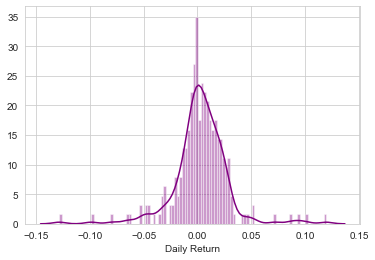

In [27]:
# NaNを取り除いてから、KDE付きのヒストグラムを描きます。
sns.distplot(AAPL['Daily Return'].dropna(),bins=100,color='purple')

このヒストグラムから、経験的な数字を知ることができます。

In [28]:
# 5パーセンタイルの位置にある変動率は？
rets['AAPL'].quantile(0.05)

-0.03421546526840809

5パーセンタイルの位置にある変動率は、-2.7%です。これは、95%の可能性で、日々の変動率がこれを下回らないことを意味します。つまり、1億円持っていたら、5%VaRは、2.7%＊1億円で、270万円です。これが、VaRの考え方です。この95％を信頼区間ということもあります。

このVaRを、未来の株価を仮想的に作り出すことによって見積もることができます。ここで使われるのが、ブラウン運動モデルとモンテカルロ（Monte Carlo）法です。それぞれどのようなものなのか、少し詳しく説明します。

#### Value at Riskをシミュレーションで計算する

未来のことは誰も分かりません。それは株価も同じ事です。ただ、これまでの経験と身につけた常識から、未来に起こり得ることを予測することは可能です。昨日まで300円だったとある会社の株価が3万円になることはあり得ません。このように、株価の予測は、これまでの価格と、取り得る値の範囲を考える事で、ある程度モデル化することができます。

色々なモデルが提案されていますが、もっとも簡単なものの1つに、ブラウン運動モデルがあります。ブラウン運動はもともと、水の中を花粉がランダムに動く現象から名付けられたものです。水に浮いた花粉は、今いる場所からランダムに次の場所に移動します。このとき、少ししか動かないこともあれば、かなりの距離動くこともあるでしょう。これはランダムな現象ですが、移動距離はこれまでの平均的な移動距離に依存します。これをモデル化したものが、ブラウン運動モデルです。

ブラウン運動モデル（正確には geometric Brownian motion (GBM)）は、確率微分方程式としてモデル化されるので、すべてを理解しようとすると、ちょっと面倒です。ポイントとしては、今いる場所にこれまでの情報が集約されていて、次の１歩は、この場所を基準に、すこしランダム性が入って決まるという点でしょう。これをマルコフ過程といったりします。それはさておき、次の式が、株価のモデルに使われる式です。

$$\frac{\Delta S}{S} = \mu\Delta t + \sigma \epsilon \sqrt{\Delta t}$$ 

Sは株価、μは平均的な変動の値、σはその標準偏差です。tは時間なのでΔtは時間の間隔、εはランダムな値です。

両辺にSを掛けると、次のように変形出来ます。

$$ \Delta S = S(\mu\Delta t + \sigma \epsilon \sqrt{\Delta t}) $$ 

右辺の最初の項はドリフト（drift）、２つ目の項はショック（shock）と呼ばれます。
ドリフトはこれまでの平均と時間間隔のかけ算なので、全体的なズレを表現し、ショックは次の瞬間どちら向きに移動するかを表現しています。

εはランダムな数字ですので、このモデルを使って株価をシミュレーションするには、ランダムな値を次々に発生させる必要があります。こうした手法を、モンテカルロ法と言うことがあります。ここでは、実際にブラウン運動モデルとモンテカルロ法を使って、株価のシミュレーションをやってみることにしましょう。

参考資料：<br>
ブラウン運動
https://ja.wikipedia.org/wiki/%E3%83%96%E3%83%A9%E3%82%A6%E3%83%B3%E9%81%8B%E5%8B%95
モンテカルロ法
https://ja.wikipedia.org/wiki/%E3%83%A2%E3%83%B3%E3%83%86%E3%82%AB%E3%83%AB%E3%83%AD%E6%B3%95


Google社の株価を使って、モンテ・カルロ法の基本的な使い方を体験してみます。

In [29]:
# 1年を基準にします。
days = 365

# 1日分の差分です。
dt = 1/days

# 日々の変動の平均を計算します。
mu = rets.mean()['GOOG']

# ボラティリティ（volatility：株価の変動の振れ幅）を変動の標準偏差で計算します。
sigma = rets.std()['GOOG']

最初の価格（starting price）と、日数、今計算した平均とボラティリティをつかって、簡単なモンテカルロ法を行う関数を作ります。

In [30]:
def stock_monte_carlo(start_price,days,mu,sigma):
    ''' この関数は、シミュレーションの結果の価格リストを返します。'''
    
    # 戻り値となる価格のリストを返します。
    price = np.zeros(days)
    price[0] = start_price
    # Shock と Driftです。
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    # 指定された日数のところまで、計算します。
    for x in range(1,days):
        #  shockを計算します
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        # Driftを計算します。
        drift[x] = mu * dt
        # これらを使って価格を計算します。
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

それでは実際にこの関数を使ってみましょう。

In [31]:
GOOG.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-07-22,1139.250000,1124.239990,1133.449951,1138.069946,1301500,1138.069946
2019-07-23,1146.900024,1131.800049,1144.000000,1146.209961,1093700,1146.209961
2019-07-24,1144.000000,1126.989990,1131.900024,1137.810059,1589800,1137.810059
2019-07-25,1141.699951,1120.920044,1137.819946,1132.119995,2209800,1132.119995
2019-07-26,1265.550049,1224.000000,1224.040039,1250.410034,4805800,1250.410034


In [32]:
GOOG.iloc[0,5]

1138.0699462890625

Text(0.5, 1.0, 'Monte Carlo Analysis for Google')

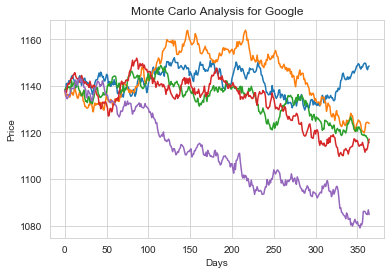

In [33]:
# 最初の終値から始めます。
start_price = GOOG.iloc[0,5]

for run in range(5):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for Google')

もう少しシミュレーションの回数を増やしてみます。（お使いの計算機の性能によっては、すこし時間がかかるかもしれません。）

In [34]:
# 回数を指定します。
runs = 10000

# 結果を保持するarrayです。
simulations = np.zeros(runs)

# これは、表示のオプションです。
np.set_printoptions(threshold=5)

for run in range(runs):    
    # 最終的な値をシミュレーション結果として保持します。
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1];


シミュレーションの結果を、ヒストグラムにしてみましょう。クォンタイルの考え方を使って、VaRを見積もります。

クォンタイル（分位数）については、以下が参考になります。
https://ja.wikipedia.org/wiki/%E5%88%86%E4%BD%8D%E6%95%B0

(array([1., 1., 0., ..., 0., 0., 1.]),
 array([1052.3956439 , 1053.36297236, 1054.33030081, ..., 1243.92667783,
        1244.89400628, 1245.86133474]),
 <a list of 200 Patch objects>)

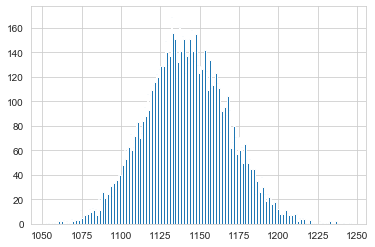

In [35]:
# 10000個の最終的なシミュレーション結果のヒストグラムです。
plt.hist(simulations,bins=200)

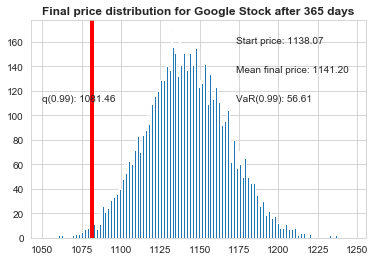

In [36]:
# 最終的な株価のヒストグラムを表示します。
plt.hist(simulations,bins=200)

# 1パーセンタイルの位置を設定します。
q = np.percentile(simulations, 1)

# プロットに追加的な情報を載せます。

# 最初の株価
plt.figtext(0.6, 0.8, s="Start price: {:0.2f}".format(start_price))
# 最終的な株価の平均値
plt.figtext(0.6, 0.7, "Mean final price: {:0.2f}".format(simulations.mean()))

# Value at Risk (信頼区間99%）
plt.figtext(0.6, 0.6, "VaR(0.99): {:0.2f}".format(start_price - q))

# 1パーセンタイル
plt.figtext(0.15, 0.6, "q(0.99): {:0.2f}".format(q))

# 1% クォンタイルに線を描きます
plt.axvline(x=q, linewidth=4, color='r')

# タイトル
plt.title("Final price distribution for Google Stock after {} days".format(days), weight='bold');

シミュレーションで、グーグルの株価のVaRを計算することができました。1年という期間、99%の信頼区間でのVaRは、1株（526.4ドル）あたり、18.38ドルであることがわかります。99%の可能性で、損失はこれ以内に収まる計算になるわけです。

お疲れ様でした。ひとまず、株価のデータ解析を終えることができました。
追加の課題をいくつか考える事ができます。

1.) このレクチャーで学んだVaRを計算する2つの方法を、ハイテク株では無い銘柄に適用してみましょう。

2.) 実際の株価でシミュレーションを行い、リスクの予測やリターンについて検証してみましょう。過去のデータから現在の株価を予測することで、これが出来るはずです。

3.) 関連のある銘柄同士の値動きに注目してみましょう。ペアトレードという投手法が実際にありますが、ここに繋がる知見を得られるかも知れません。

(注意）英語のレクチャーをそのまま訳していますが、このシミュレーションの解釈は恐らく間違えています。全体的な流れに問題はないので、それほど神経質にならなくても良いかと思いますが、詳しく知りたい方は過去のQ&Aを参照するか、直接お問い合わせください。